In [1]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
%run ../setup_notebook.ipynb

In [75]:
# general imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import colors as mcolors
import seaborn as sns
from subsets_analysis import Subsets
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from run_functions import filter_trials
import time

In [3]:
# notebook specific imports
import pickle
import utils_funcs as utils
import re

In [4]:
# global plotting params
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.markersize': 15}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)


In [5]:
mice_dicts = [
    
{'mouse_id': 'J048', 'run_numbers': [27,28,29,30,32], 'runs': []},
{'mouse_id': 'RL048', 'run_numbers': [23, 24, 25, 28, 29], 'runs': []},
{'mouse_id': 'J063', 'run_numbers': [8,9,10,11,12,13,14], 'runs': []},
{'mouse_id': 'J064', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
{'mouse_id': 'J065', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
    
]

In [6]:
for mouse_dict in mice_dicts:
    for run_number in mouse_dict['run_numbers']:
        
        pkl_path = os.path.join(path_to_vape, 'run_pkls', mouse_dict['mouse_id'], 
                                'run{}.pkl'.format(run_number))

        with open(pkl_path, 'rb') as f:
            run = pickle.load(f)
            
        mouse_dict['runs'].append(run)
                

In [7]:
def trial_outcomes(outcome):

    go_outcome = []
    nogo_outcome = []

    for t in outcome:
        if t == 'hit':
            go_outcome.append(True)
        elif t == 'miss':
            go_outcome.append(False)
        elif t =='cr':
            nogo_outcome.append(False)
        elif t == 'fp':
            nogo_outcome.append(True)

    go_outcome = np.array(go_outcome)
    nogo_outcome = np.array(nogo_outcome)
    
    return go_outcome, nogo_outcome

In [8]:
def get_subset_dprime(run):
    
    ''' get the d-prime for each subset in a run.
        Returns nan if < 10 trials of a subset in a session
        '''

    good_idxs = filter_trials(run, dp_thresh=1)
    outcome = np.array(run.outcome)[good_idxs]
    trial_info = np.array(run.trial_info)[good_idxs]
    print('{}% of trials good'.format(round(sum(good_idxs) / len(good_idxs) * 100), 2))
    
    go_outcome, nogo_outcome = trial_outcomes(outcome)
    trial_subsets = []
    
    for i, info in enumerate(trial_info):
        if 'Nogo Trial' in info:
            continue
        elif 'all_cells_stimulated' in info:
            trial_subsets.append(150)
        elif 'Subset cells experiment' in info:
            trial_subset = int(re.search('(?<=stimulating )(.*)(?= cells)', info).group(0))
            trial_subsets.append(trial_subset)

    group_dict = {
        0: '0',
        5: '5-10',
        10: '5-10',
        20: '20-30',
        30: '20-30',
        40: '40-50',
        50: '40-50',
        150: '150'
    }
    
    trial_subsets = [group_dict[sub] for sub in trial_subsets]
    trial_subsets = np.array(trial_subsets)
    subsets = ['0', '5-10', '20-30', '40-50', '150']
        
    fp_rate = sum(nogo_outcome) / len(nogo_outcome)
    subset_rate = []
        
    assert len(go_outcome) == len(trial_subsets), '{} {}'.format(len(trial_subsets), len(go_outcome))
    for sub in subsets:
        subset_idx = np.where(trial_subsets == sub)[0]
        if len(subset_idx) < 10:
            subset_rate.append(np.nan)
        else:
            subset_rate.append(sum(go_outcome[subset_idx]) / len(subset_idx))

    subsets_dprime = [utils.d_prime(rate, fp_rate) for rate in subset_rate]
    #subsets_dprime = subset_rate
    return subsets, subsets_dprime, fp_rate
    

In [9]:
def get_psychometric(runs):
    
    across_sessions = []
    fp_rates = []

    
    for run in runs:
        n_hits = len(np.where(run.outcome=='hit')[0])
        n_go = len(np.where(np.array(run.trial_type)=='go')[0])
        session_hitrate = n_hits / n_go
        session_fprate = len(np.where(run.outcome=='fp')[0]) / (len(run.outcome) - n_go)
        
        session_dprime = utils.d_prime(session_hitrate, session_fprate)
        
        if session_dprime < 0.6:
            continue
        
        global subsets  # hackkkkkkk
        subsets, subsets_dprime, fp_rate = get_subset_dprime(run)

        across_sessions.append(subsets_dprime)
        fp_rates.append(fp_rate)

    across_sessions = np.array(across_sessions)   
    meaned = np.nanmean(across_sessions, 0)
    
    # Currently returning mean of fp rate to avoid
    # session speicific info in dict
    return meaned, np.mean(fp_rates)

In [10]:
for mouse_dict in mice_dicts:
    dprimes, fp_rate = get_psychometric(mouse_dict['runs'])
    mouse_dict['dprimes'] = dprimes
    mouse_dict['fp_rate'] = fp_rate

across_mice = np.array([mouse_dict['dprimes'] for mouse_dict in mice_dicts])

71% of trials good
67% of trials good
62% of trials good
89% of trials good
91% of trials good
64% of trials good
57% of trials good
65% of trials good
79% of trials good
82% of trials good
96% of trials good
86% of trials good
87% of trials good
74% of trials good
86% of trials good
75% of trials good
97% of trials good
84% of trials good
94% of trials good
89% of trials good
69% of trials good
76% of trials good
80% of trials good
84% of trials good
78% of trials good


In [11]:
np.unique(Subsets(run).trial_subsets)

array([  0,   5,  10,  20,  30,  40,  50, 150])

(0, 3)

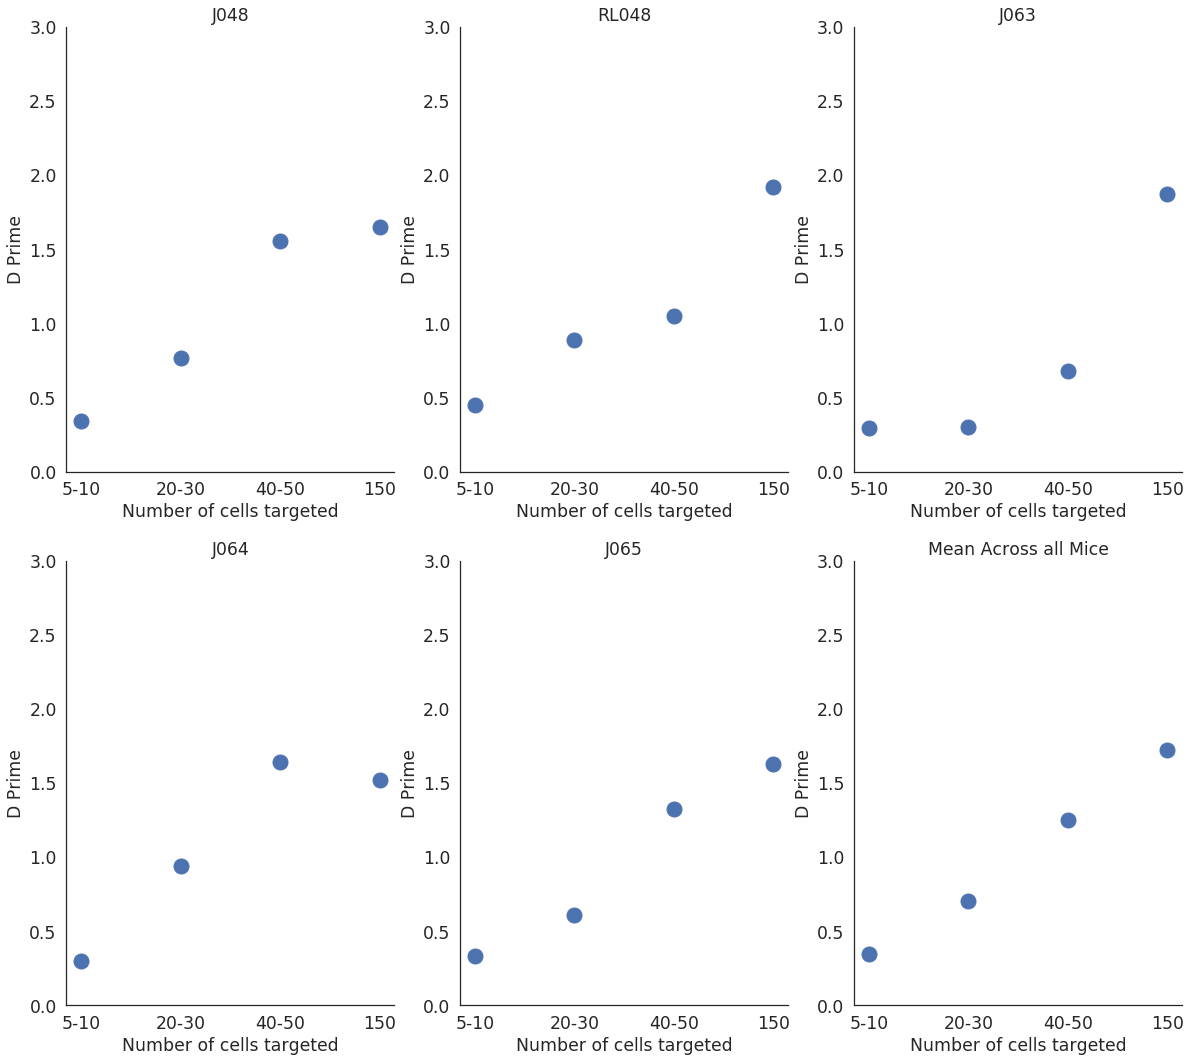

In [12]:
plt.figure(figsize=(20,18))
y_min = 0
y_max = 3


plot_idx = 0
for mouse_dict in mice_dicts:
    plot_idx += 1
    plt.subplot(2, 3, plot_idx)
    plt.plot(subsets, mouse_dict['dprimes'], '.', markersize=30)
    plt.xlabel('Number of cells targeted')
    plt.ylabel('D Prime')
    plt.title(mouse_dict['mouse_id'])
    plt.ylim((y_min, y_max))
    
plt.subplot(2,3,6)
plt.plot(subsets, np.nanmean(across_mice, 0), '.', markersize=30)
plt.xlabel('Number of cells targeted')
plt.ylabel('D Prime')
plt.title('Mean Across all Mice')
plt.ylim((y_min, y_max))


In [390]:
run = mice_dicts[3]['runs'][2]
run.__dict__.keys()
run.hit_rate


0.7422680412371134

In [14]:
def trial_binner(arr):
    
    group_dict = {
        
        0: '0',
        5: '5-10',
        10: '5-10',
        20: '20-30',
        30: '20-30',
        40: '40-50',
        50: '40-50',
        150: '150'
        
    }

    return np.array([group_dict[a] for a in arr])

In [402]:
def lick_raster(run, grid, run_number, only_good=False):
    
    binned_licks = np.array(run.binned_licks)
    trial_type = np.array(run.trial_type)
    trial_subsets = Subsets(run).trial_subsets
    outcome = run.outcome
    
    # Do you only want to plot good trials?
    if only_good:
        good_idxs = filter_trials(run)
        binned_licks = binned_licks[good_idxs]
        trial_type = trial_type[good_idxs]
        trial_subsets = trial_subsets[good_idxs]
        outcome = outcome[good_idxs]

    # Sort variables by whether the number of cells stimmed
    trial_idxs = np.argsort(trial_subsets)
    sorted_licks = binned_licks[trial_idxs]
    sorted_outcome = outcome[trial_idxs]
    sorted_subsets = trial_subsets[trial_idxs]
    sorted_subsets = trial_binner(sorted_subsets)
    
    # Map a plot color to each subset size
    colors = ['black', 'dimgrey', 'darkgrey', 'silver', 'khaki']
    subsets = ['150', '40-50', '20-30', '5-10', '0']

    color_map = {}
    for i, sub in enumerate(subsets):
        color_map[sub] = colors[i] 
    subset_colors = [color_map[i] for i in sorted_subsets]
    
    # Init the parent figure 
    #fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpecFromSubplotSpec(1, 2, grid, width_ratios=[4, 1]) 
    #gs.update(wspace=0) # set the spacing between axes. 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    # Plot lick rasters 
    line_pos = []
    for i, rast in enumerate(sorted_licks):

        color=subset_colors[i]
        y_axis = np.ones(len(rast)) + i

        if sorted_subsets[i] != sorted_subsets[i-1] and i != 0:
            ax0.axhline(y=i, ls='--', color='darkolivegreen')
            line_pos.append(i)
            
        ax0.plot(rast/1000, y_axis,'.', c=color, markersize=12)

    # Get positions of dividing lines so know where to put y tick labels
    line_pos.insert(0,0)
    line_pos.append(len(sorted_subsets))
    subset_centre = [(line_pos[i] + line_pos[i+1]) / 2 for i in range(len(line_pos)-1)]
    
    # Setup raster axis 
    ax0.fill_between([0,1], 0, len(sorted_licks), color='lightblue', alpha=0.5)
    ax0.set_xlim((0,2))
    ax0.set_xlabel('Time (s)')
    ax0.set_ylim((0,len(sorted_licks)+1))
    ax0.set_yticks(subset_centre)
    ax0.set_yticklabels(np.flip(subsets))
    ax0.set_ylabel('Number of Cells Stimulated')
    ax0.set_title('Run Number {}\nSession d-prime = {}'.
              format(run_number, round(utils.d_prime(run.hit_rate, run.fp_rate),2)))
    sns.despine()
    
    # Map trial types to ints so can express as colormap
    int_map = {
        'hit': 3,
        'miss': 2,
        'fp': 1,
        'cr': 0
    }
    
    int_mapped = [int_map[out] for out in np.flip(sorted_outcome)]        
    bar_width = 10
    bar_data = np.stack([int_mapped for _ in range(bar_width)], axis=1)

    # Color the trial int array
    cols =  [mcolors.to_rgba('black') ,mcolors.to_rgba('pink'),
            mcolors.to_rgba('lightblue') , mcolors.to_rgba('red')]
    cm = LinearSegmentedColormap.from_list('hit_miss', cols, N=4)
    
    # Build the colorbar
    im = ax1.imshow(bar_data, cmap=cm)
    ax1.set_axis_off()
    cbar = plt.colorbar(im)
    cbar.set_ticks([0.2,1.1,1.75,2.5])
    cbar.set_ticklabels(['Correct\nRejection', 'False\nPositive', 'Miss', 'Hit'])
    #plt.tight_layout(w_pad=0)
    
    return gs

Text(0.5, 0.98, 'J048')

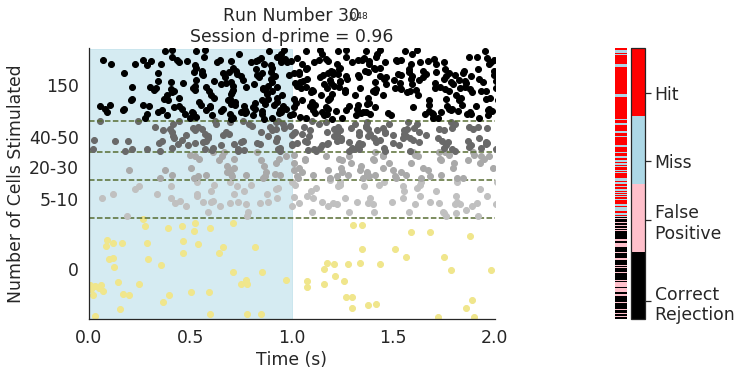

In [412]:
fig = plt.figure(figsize=(10,5))
mouse_dict = mice_dicts[0]
outer = gridspec.GridSpec(1, 1, hspace= 0.3, wspace=0.65)
for i, run in enumerate(mouse_dict['runs']):
    if i == 3:
        gs = lick_raster(run, outer[0], mouse_dict['run_numbers'][i])

fig.suptitle(mouse_dict['mouse_id'], fontsize=9)

Text(0.5, 0.98, 'J048')

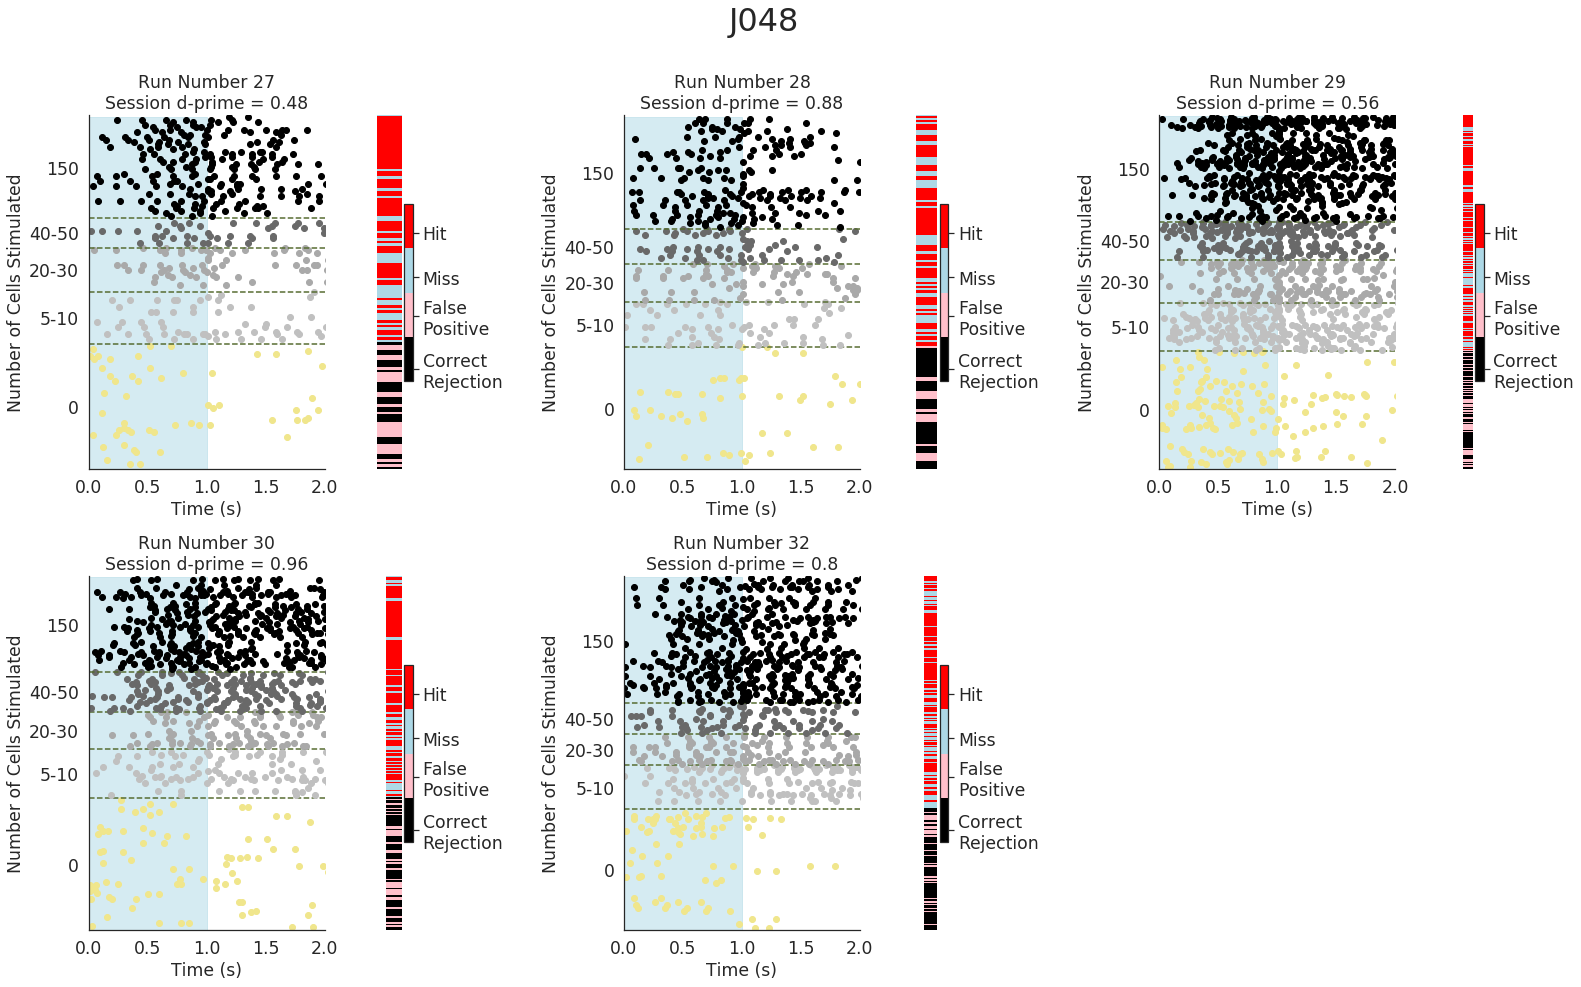

In [406]:
fig = plt.figure(figsize=(25,15))
mouse_dict = mice_dicts[0]
outer = gridspec.GridSpec(2, 3, hspace= 0.3, wspace=0.65)
for i, run in enumerate(mouse_dict['runs']):
    
    gs = lick_raster(run, outer[i], mouse_dict['run_numbers'][i])

fig.suptitle(mouse_dict['mouse_id'], fontsize=32)

In [401]:
run = 

6

In [286]:
line_pos

[0, 62, 78, 95, 116, 159]

In [287]:
subset_centre

[31.0, 70.0, 86.5, 105.5, 137.5]

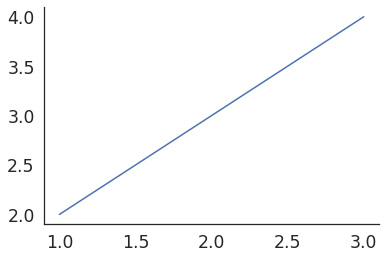

In [174]:
plt.plot([1,2,3], [2,3,4])


## Not sure what the purpose of this code is

In [ ]:
def subsets_hit_fp(run):
    
    ''' Hacky function code copied from above to get out
        dprimes calculated across all sessions
        '''
    
    go_outcome, nogo_outcome = trial_outcomes(run.outcome)
    
    trial_subsets = []

    for i, info in enumerate(run.trial_info):
        if 'Nogo Trial' in info:
            continue
        elif 'all_cells_stimulated' in info:
            trial_subsets.append(150)
        elif 'Subset cells experiment' in info:
            trial_subset = int(re.search('(?<=stimulating )(.*)(?= cells)', info).group(0))
            trial_subsets.append(trial_subset)

    trial_subsets = np.array(trial_subsets)
    global subsets # lol
    subsets = np.sort(np.unique(trial_subsets))
    assert len(trial_subsets) == len(go_outcome), 'dsdsd {} {}'.format(len(trial_subsets), len(go_outcome))
    
    subby = [] # list of lists
    
    for sub in subsets:
        subset_idx = np.where(trial_subsets == sub)[0]
        subby.append(go_outcome[subset_idx])
        
        
    fp_rate = sum(nogo_outcome) / len(nogo_outcome)
    
    return subby, fp_rate
        

In [ ]:
fp_rates = []


for i, run_number in enumerate(run_numbers):
    pkl_path = os.path.join(path_to_vape, 'run_pkls', mouse_id, 'run{}.pkl'.format(run_number))
    print(i)
    with open(pkl_path, 'rb') as f:
        run = pickle.load(f)
        
    subby, fp_rate = subsets_hit_fp(run)
    fp_rates.append(fp_rate)
    
    if i == 0:    
        all_subbys = subby
    
    else:
        for i, lst in enumerate(all_subbys):   
            all_subbys[i] = np.append(lst, subby[i])

In [ ]:
# change this need to sum and divide by len across all sessions
fp_rate = np.mean(fp_rates)
fp_rate

In [ ]:
hit_rates = []

dprimes = []

for i,sub in enumerate(all_subbys):
    hit_rate = sum(sub) / len(sub)
    print(len(sub))
    dprimes.append(utils.d_prime(hit_rate, fp_rate))

In [ ]:
plt.plot(subsets, dprimes, '.')
plt.xlabel('Number of Cells Targeted')
plt.ylabel('d-prime')
plt.title('{} number of sessions = {}'.format(mouse_id, len(fp_rates)))
plt.ylim((-0.1,1.5))